This is a starter file of network simulation

## Import the required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import resize
from skimage.io import imread

from solcore.structure import Junction
from solcore.solar_cell import SolarCell
from solcore.light_source import LightSource
from solcore.spice import solve_quasi_3D


	Welcome to Solcore - version 5.5.2
	Copyright (c) 2018, Imperial College London. All rights reserved.
	Software released under the GNU Lesser General Public License.

No module named 'solcore.poisson_drift_diffusion.ddModel'


## Load the pattern of the contact

In [2]:
contactsMask = imread('masks_sq.png')

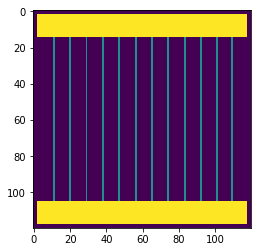

In [3]:
plt.imshow(contactsMask)

## Reduce the shape to 1/4 because of symmetry

In [4]:
nx, ny = contactsMask.shape
# For symmetry arguments (not completely true for the illumination), we can mode just 1/4 of the device and then
# multiply the current by 4
contactsMask = contactsMask[int(nx / 2):, int(ny / 2):]

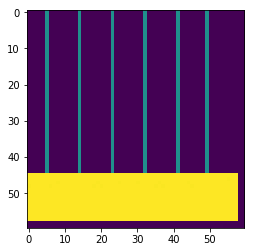

In [5]:
plt.imshow(contactsMask)

## Make illumination

In [6]:
from os.path import join
import os
this_path=os.getcwd()
image_file=join(this_path,"masks_illumination.png")

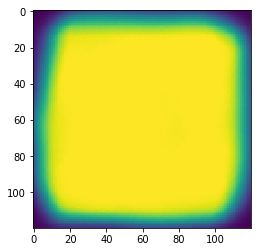

In [7]:
img=imread(image_file)
plt.imshow(img)

In [8]:
illuminationMask=(img*255).astype(np.int)
illuminationMask=img[int(nx / 2):, int(ny / 2):]

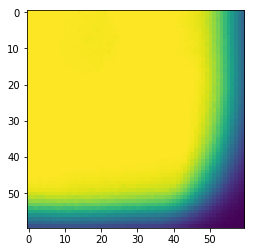

In [9]:
plt.imshow(illuminationMask)

In [10]:
np.max(illuminationMask)

255

In [11]:
contactsMask = (resize(contactsMask, illuminationMask.shape)*255).astype(np.int)

nnx, nny = illuminationMask.shape
assert illuminationMask.shape==contactsMask.shape
# assert int(nx/8)==nnx
# assert int(ny/8)==nny

C:\Users\kanhu\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


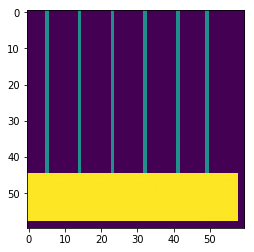

In [12]:
plt.imshow(contactsMask)

## Set solar cell parameters

In [13]:
# Size of the pixels (m)
Lx = 10e-6
Ly = 10e-6

# Height of the metal fingers (m)
h = 2.2e-6

# Contact resistance (Ohm m2)
Rcontact = 3e-10

# Resistivity metal fingers (Ohm m)
Rline = 2e-8

# Bias (V)
vini = 0
vfin = 3
step = 0.01

T = 298

## Set the parameter of solar cells

### Load EQE

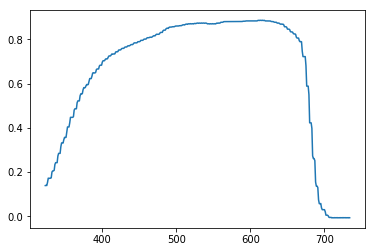

In [14]:
from scipy.interpolate import interp1d

top_qe_data=np.loadtxt("azure_3c44_top.csv",delimiter="\t")

plt.plot(top_qe_data[:,0],top_qe_data[:,1])

top_qe=interp1d(top_qe_data[:,0],top_qe_data[:,1])

## Set other solar cell parameters

In [15]:
ge_cell = Junction(kind='2D', T=T, reff=1, jref=300, Eg=0.66, A=1, R_sheet_top=100, R_sheet_bot=1e-16,
                       R_shunt=1e16, n=3.5)
gaas_cell = Junction(kind='2D', T=T, reff=1, jref=300, Eg=1.4, A=1, R_sheet_top=100, R_sheet_bot=1e-16,
                        R_shunt=1e16, n=3.5)
ingap_cell = Junction(kind='2D', T=T, reff=0.5, jref=300, Eg=1.8, A=1, R_sheet_top=100, R_sheet_bot=100,
                        R_shunt=1e16, n=3.5)



We only use top cell in this simulation

In [16]:
my_solar_cell = SolarCell([ingap_cell], T=T)

### Set the light source

In [17]:
wl = np.linspace(350, 2000, 301) * 1e-9
light_source = LightSource(source_type='standard', version='AM1.5g', x=wl, output_units='photon_flux_per_m',
                           concentration=100)

options = {'light_iv': True, 'wavelength': wl, 'light_source': light_source}

### Launch the solver

In [18]:
V, I, Vall, Vmet = solve_quasi_3D(my_solar_cell, illuminationMask, contactsMask, options=options, Lx=Lx, Ly=Ly, h=h,
                                  R_back=1e-16, R_contact=Rcontact, R_line=Rline, bias_start=vini, bias_end=vfin,
                                  bias_step=step)

# Since we model 1/4 of the device, we multiply the current by 4
I = I * 4

Solving 1D Solar Cell...
Solving optics of the solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
... Done!

Solving quasi-3D Solar Cell...
... Done!!


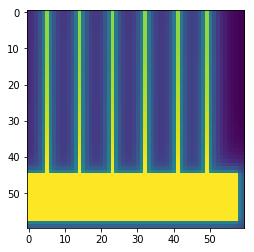

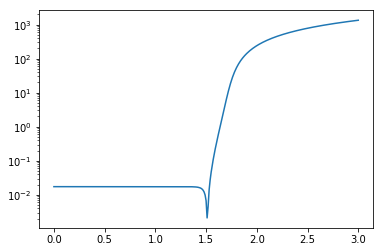

In [19]:
plt.figure(1)
plt.imshow(Vall[:, :, -2, -1])

plt.figure(2)
plt.semilogy(V, abs(I))
plt.show()

## Plot in linear scale

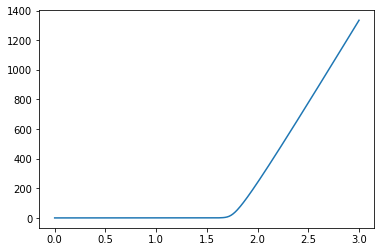

In [20]:
plt.plot(V, I)

## Export the I-V characteristics into a CSV file

In [21]:
output_iv=np.vstack([V,I]).T
np.savetxt('iv_result.csv',output_iv,delimiter=',')